In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
 # This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
query = calc_temps('2016-01-01', '2016-12-31')
print(query)

[(56.0, 74.14421827631008, 84.0)]


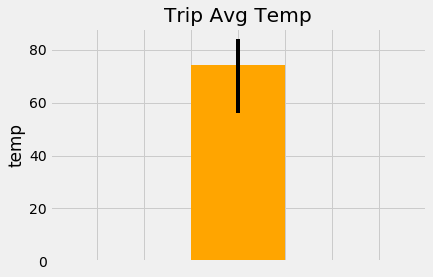

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


#plotting values extract
xaxis = [1]
yaxis = query[0][1]
lower_bound = query[0][0]
upper_bound = query[0][2]

#initial chart
plt.bar(xaxis, yaxis, width=0.5, 
        yerr = np.array([[yaxis-lower_bound ,upper_bound - yaxis]]).T, 
        color = 'orange')
#hide xticks
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

plt.xlim(0,2)
plt.title("Trip Avg Temp")
plt.ylabel("temp")
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.

start_date = '2017-08-01'
end_date = '2017-08-07'

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]

results = session.query(* sel).\
            group_by(Measurement.station).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            order_by(func.sum(Measurement.prcp)).all()

for row in results:
    print(row)

('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.0, 21.33556, -157.71139, 19.5)
('USC00519397', 'WAIKIKI 717.2, HI US', 0.04, 21.2716, -157.8168, 3.0)
('USC00519281', 'WAIHEE 837.5, HI US', 0.06, 21.45167, -157.84888999999998, 32.9)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.22, 21.5213, -157.8374, 7.0)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 0.36, 21.3331, -157.8025, 152.4)


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates

trip_dates = pd.date_range(start=start_date,end=end_date)
# Strip off the year and save a list of strings in the format %m-%d

dates = trip_dates.strftime('%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals = [daily_normals(date)[0] for date in dates]
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
holiday_df = pd.DataFrame(np.array(normals), columns = ['min', 'avg','max'])
holiday_df['date'] = trip_dates
holiday_df.set_index('date', inplace = True)
holiday_df

,min,avg,max
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


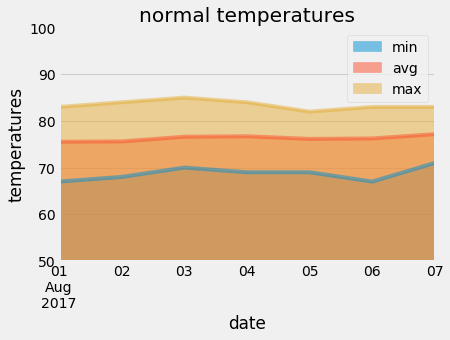

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
holiday_df.plot.area(stacked = False)
plt.title('normal temperatures')
plt.xlabel('date')
plt.ylabel('temperatures')
plt.ylim(50,100)
plt.show()

## Close Session

In [17]:
session.close()